In [1]:
import geopandas as gpd
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
from matplotlib.patches import Patch, Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette, cut_tree
from sklearn.preprocessing import scale

In [2]:
# Load all features
tjhd_df = pd.read_csv('output/non_outlier_TJHD_ZCTA_transformed_features.csv')

# Subset to the ZCTAs and features of interest
ZCTAs_to_exclude = [22904, 24581, 22952, 24483, 23015, 24521, 23192, 23102, 23038]
tjhd_df = tjhd_df.loc[~tjhd_df['ZCTA'].apply(lambda x: x in ZCTAs_to_exclude)].set_index('ZCTA')

for col in ['Rural_Pct', 'Age_Cat0_Pct', 'Age_Cat1_Pct', 
            'Age_Cat2_Pct', 'Age_Cat3_Pct', 'Age_Cat4_Pct']:
    del tjhd_df[col]
print(tjhd_df.columns)

Index(['Age_Child_Pct', 'Age_Adult_Pct', 'Age_Retired_Pct', 'Inc_Cat0_Pct',
       'Inc_Cat1_Pct', 'Inc_Cat2_Pct', 'Bachelor_Plus_Pct', 'Black_Pct',
       'Asian_Pct', 'Hispanic_Pct', 'Population_Density'],
      dtype='object')


### Hierarchical Clustering Dendrogram

In [3]:
ABV_THRSHLD_CLR = '#494949'
HC_colors = ['#997f5f', '#ef3b2c', '#fcc5c0', '#33a02c', '#b2df8a', '#6baed6', '#bfd3e6']
MS_colors = ['#997f5f', '#ef3b2c', '#ad074a', '#ff7f00', '#fcc5c0', '#33a02c',
             '#b2df8a', '#cab2d6', '#6a51a3', '#b2df8a', '#6baed6', '#bfd3e6']
set_link_color_palette(HC_colors)

In [4]:
# Perform hierarchical clustering
df_linkage = linkage(scale(tjhd_df), method='ward', metric='euclidean')

In [5]:
# Euclidean distance cutoff
threshold = 6.25

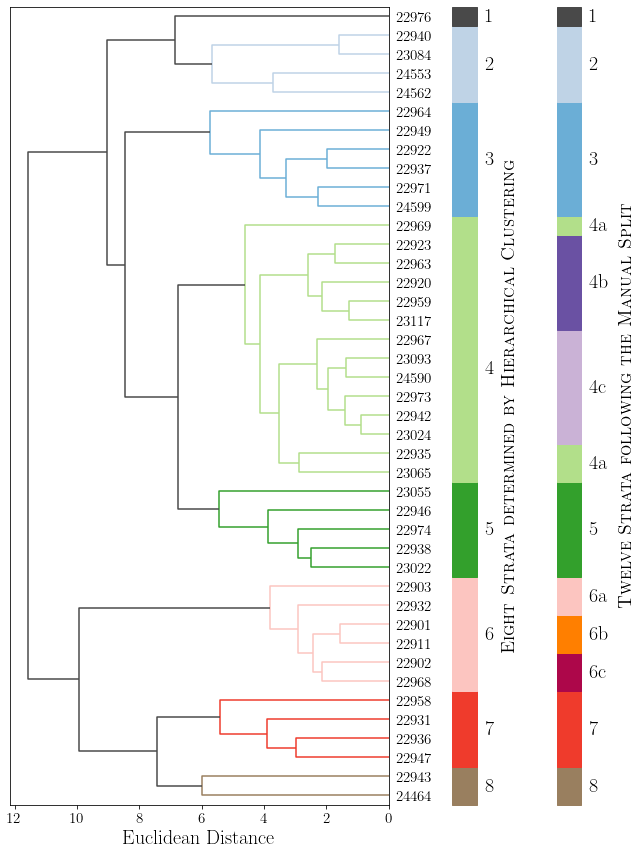

In [6]:
# Plot dendrogram
unit_height = 1/42
fig, ax = plt.subplots(figsize=(9, 12), ncols=2, gridspec_kw={'width_ratios': [2, 1]})
R = dendrogram(df_linkage, labels=tjhd_df.index, color_threshold=threshold,
               leaf_font_size=14, above_threshold_color=ABV_THRSHLD_CLR,
               ax=ax[0], orientation='left', distance_sort='descending')

# Add hierarchical clustering colorbar
ax[1].axis('off')
for clr, start, i in zip(HC_colors + [ABV_THRSHLD_CLR],
                         [0, 2, 6, 12, 17, 31, 37, 41, 42],
                         [2, 4, 6, 5, 14, 6, 4, 1]):
    rect = Rectangle((0.05, start*unit_height), width=0.13, height=i*unit_height, 
                     color=clr, transform=ax[1].transAxes,
                     clip_on=False)
    ax[1].add_patch(rect)

for i, stratum in zip([1, 7, 17, 28, 45, 67, 77, 82], 
                      [8, 7, 6, 5, 4, 3, 2, 1]):
    plt.text(0.22, (unit_height/2)*i, stratum, fontsize=20,
             transform=ax[1].transAxes, ha='left', va='bottom')
plt.text(0.35, 0.5, r'\textsc{Eight Strata determined by Hierarchical Clustering}', fontsize=18,
         transform=ax[1].transAxes, ha='center', va='center', rotation=90)        

# Add manual split colorbar
for clr, start, i in zip(MS_colors + [ABV_THRSHLD_CLR], 
                         [0, 2, 6, 8, 10, 12, 17, 19, 25, 30, 31, 37, 41, 42], 
                         [2, 4, 2, 2, 2, 5, 2, 6, 5, 1, 6, 4, 1]):
    rect = Rectangle((0.6, start*unit_height), width=0.13, height=i*unit_height, 
                     color=clr, transform=ax[1].transAxes,
                     clip_on=False)
    ax[1].add_patch(rect)

for i, stratum in zip([1, 7, 13, 17, 21, 28, 35, 43, 54, 60, 67, 77, 82], 
                      [8, 7, '6c', '6b', '6a', 5, '4a', '4c', '4b', '4a', 3, 2, 1]):
    plt.text(0.77, (unit_height/2)*i, stratum, fontsize=20,
             transform=ax[1].transAxes, ha='left', va='bottom')
plt.text(0.97, 0.5, r'\textsc{Twelve Strata following the Manual Split}', fontsize=18,
         transform=ax[1].transAxes, ha='center', va='center', rotation=90)
ax[0].set_xlabel('Euclidean Distance', fontsize=20)
ax[0].tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('output/HC_dendrogram.png', transparent=True, dpi=600)
plt.show()
plt.close()

In [7]:
def get_ZCTA_colors_df(den):
    """
    Returns a list of labels and a list of the corresponding colors of each label
    in the dendrogram.
    """
    eps = 0.0001

    position_color = []
    for icoord, dcoord, color in zip(den['icoord'], den['dcoord'], den['color_list']):
        if dcoord[0] < eps:
            position_color.append((icoord[0], color))
        if dcoord[3] < eps:
            position_color.append((icoord[3], color))
    
    position_color = sorted(position_color, key=lambda tup: tup[0])
    
    return pd.DataFrame({'ZCTA5CE10': den['ivl'], 'Facecolor': [color for _, color in position_color]})


ZCTA_colors_df = get_ZCTA_colors_df(R)

### Hierarchical Clustering Map

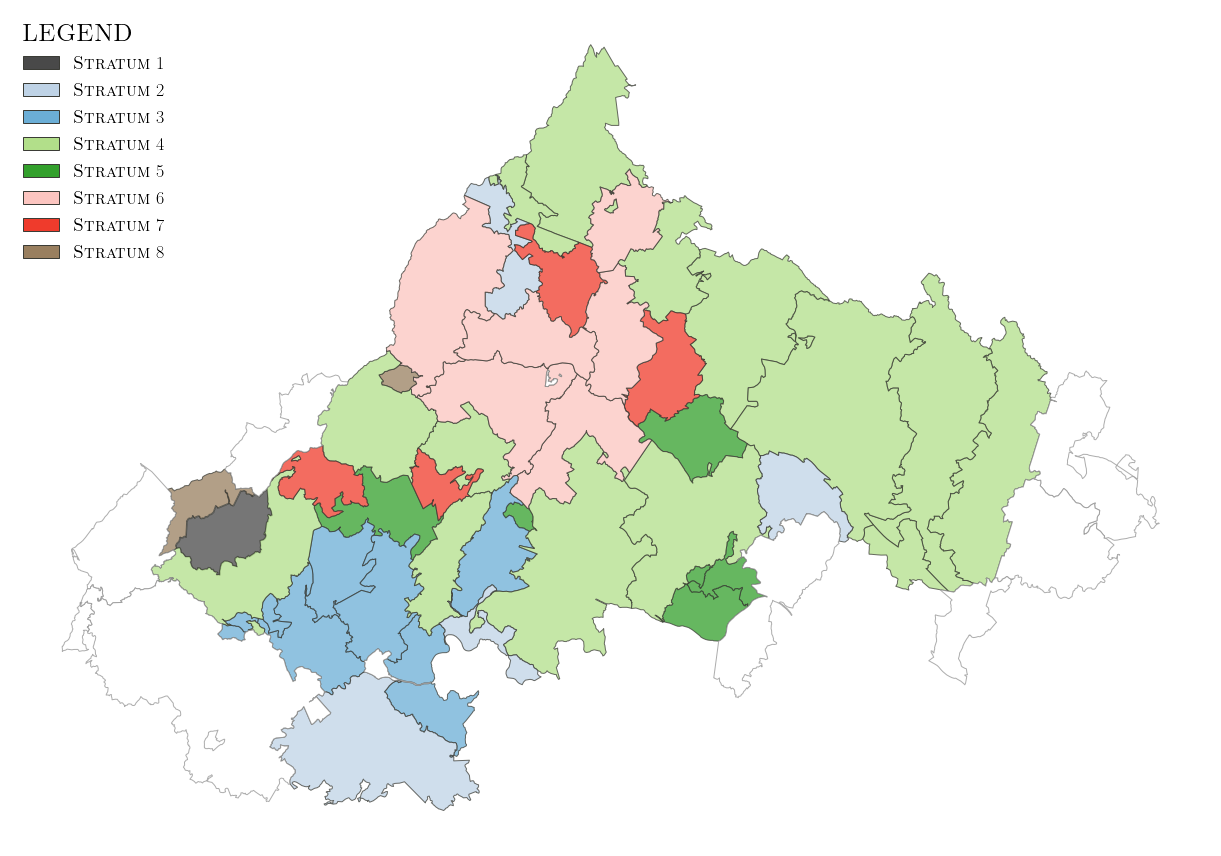

In [8]:
# A geopandas GeoDataFrame of the Zip Code Tabulation Areas of interest.
ZCTAs_gdf = gpd.read_file('GIS_data/TJHD_ZCTAs/TJHD_ZCTAs.shp')
ZCTAs_gdf['ZCTA5CE10'] = ZCTAs_gdf['ZCTA5CE10'].astype('int')

fig, ax = plt.subplots(figsize=(21, 12))
ax.set_aspect('equal')
ax.axis('off')

# Plot zctas
ZCTAs_gdf = ZCTAs_gdf.merge(ZCTA_colors_df, how='outer', on='ZCTA5CE10')
ZCTAs_gdf['Facecolor'].fillna(value='#ffffff', inplace=True)
for lbl, lbl_gdf in ZCTAs_gdf.groupby('Facecolor'):
    if lbl == '#ffffff':
        lbl_gdf.plot(ax=ax, alpha=0.75, facecolor=lbl, edgecolor='#939393')
    else:
        lbl_gdf.plot(ax=ax, alpha=0.75, facecolor=lbl, edgecolor='#3B3C3666')

ID_color_pairs = [(1, '#494949'), (2, '#bfd3e6'), (3, '#6baed6'), (4, '#b2df8a'), (5, '#33a02c'), 
                  (6, '#fcc5c0'), (7, '#ef3b2c'), (8, '#997f5f')]

color_ID_dict = {color: ID for ID, color in ID_color_pairs}
ZCTA_colors_df['ID'] = ZCTA_colors_df['Facecolor'].apply(lambda color: color_ID_dict[color])

legend_elements = [Patch(facecolor=color, 
                         edgecolor=[59 / 255.0, 60 / 255.0, 54 / 255.0, 1], 
                         label=r'\textsc{Stratum} %s' % ID) \
                   for ID, color in ID_color_pairs]
legend = plt.legend(handles=legend_elements, loc=2, fontsize=18,
                    frameon=False, 
                    title=r'\textsc{LEGEND}', title_fontsize=24)
legend._legend_box.align = 'left'
plt.grid(False)
plt.tight_layout()
plt.savefig('output/HC_map.png', transparent=True, dpi=600)
plt.show()
plt.close()

### Manual Split Map

In [9]:
MS_ZCTA_colors_df = pd.read_csv(f'other_data/manual_split_ZCTA_colors.csv')

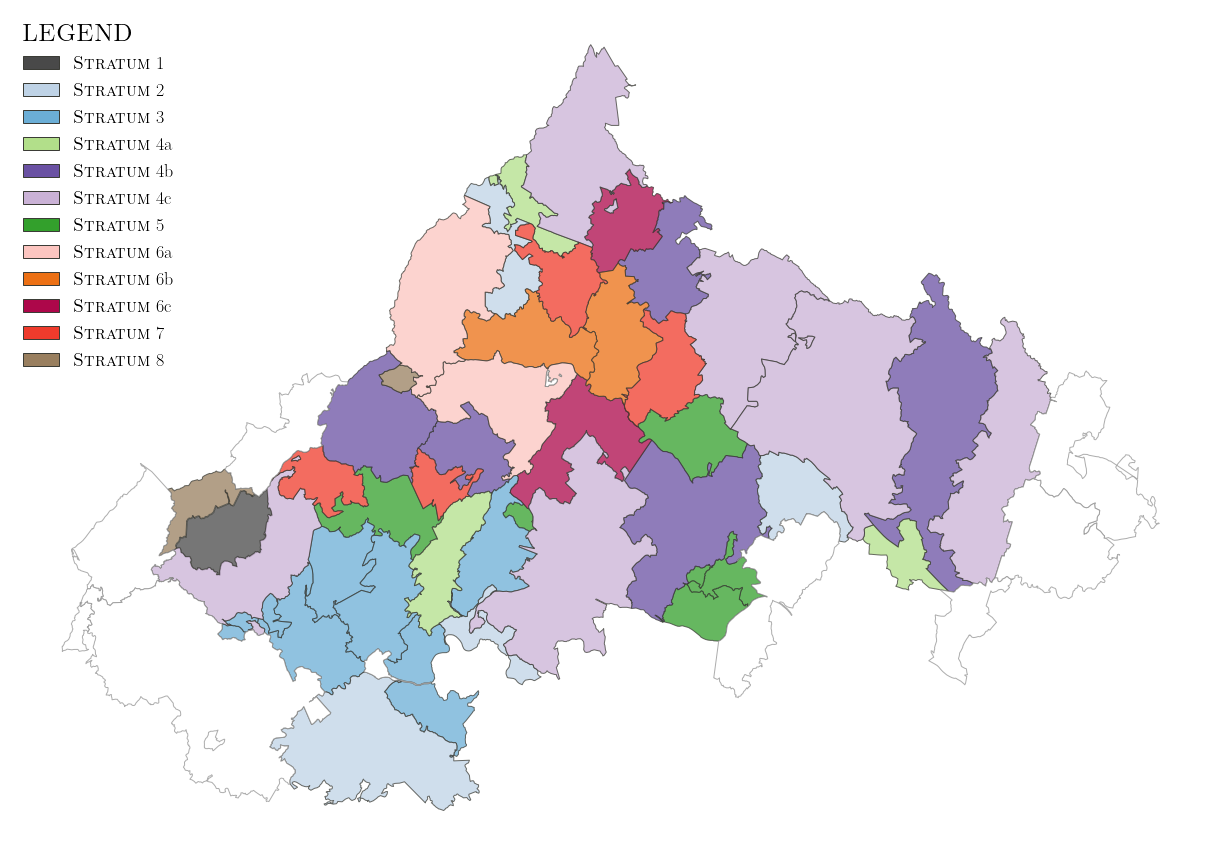

In [10]:
# A geopandas GeoDataFrame of the Zip Code Tabulation Areas of interest.
ZCTAs_gdf = gpd.read_file('GIS_data/TJHD_ZCTAs/TJHD_ZCTAs.shp')
ZCTAs_gdf['ZCTA5CE10'] = ZCTAs_gdf['ZCTA5CE10'].astype('int')

fig, ax = plt.subplots(figsize=(21, 12))
ax.set_aspect('equal')
ax.axis('off')

# Plot zctas
ZCTAs_gdf = ZCTAs_gdf.merge(MS_ZCTA_colors_df, how='outer', on='ZCTA5CE10')
ZCTAs_gdf['Facecolor'].fillna(value='#ffffff', inplace=True)
for lbl, lbl_gdf in ZCTAs_gdf.groupby('Facecolor'):
    if lbl == '#ffffff':
        lbl_gdf.plot(ax=ax, alpha=0.75, facecolor=lbl, edgecolor='#939393')
    else:
        lbl_gdf.plot(ax=ax, alpha=0.75, facecolor=lbl, edgecolor='#3B3C3666')

    ID_color_pairs = [(1, '#494949'), (2, '#bfd3e6'), (3, '#6baed6'), ('4a', '#b2df8a'), ('4b', '#6a51a3'), 
                      ('4c', '#cab2d6'), (5, '#33a02c'), ('6a', '#fcc5c0'), ('6b', '#ec7014'), ('6c', '#ad074a'), 
                      (7, '#ef3b2c'), (8, '#997f5f')]
    
    color_ID_dict = {color: ID for ID, color in ID_color_pairs}
    MS_ZCTA_colors_df['ID'] = MS_ZCTA_colors_df['Facecolor'].apply(lambda color: color_ID_dict[color])
    
    legend_elements = [Patch(facecolor=color, edgecolor="#3B3C36", label=r'\textsc{Stratum} %s' % ID) \
                       for ID, color in ID_color_pairs]
    legend = plt.legend(handles=legend_elements, loc=2, fontsize=18,
                        frameon=False, 
                        title=r'\textsc{LEGEND}', title_fontsize=24)
    legend._legend_box.align = 'left'
                        
plt.grid(False)
plt.tight_layout()
plt.savefig('output/MS_map.png', transparent=True, dpi=600)
plt.show()
plt.close()